In [284]:
# import PyQt5
# %matplotlib qt
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.transforms as mtransforms

import sys
sys.path.append("/Users/prachigarg/Desktop/assgn5/src") 
from cp_hw5 import integrate_poisson, integrate_frankot, load_sources

from skimage.transform import resize

In [285]:
def normalize_tiff(img):
    return img/(2.0**16.0 - 1.0)

In [286]:
def convert_xyz(img):
    M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
     [0.2126729, 0.7151522, 0.0721750],
     [0.0193339, 0.1191920, 0.9503041]])
    xyz = np.matmul(img, M_RGB_XYZ)
    lumi_channel = xyz[:, :, 1]
    return lumi_channel
def crop(img):
    return img[1200:-200, 1800:4300]

0.0 0.667551689936675
0 0


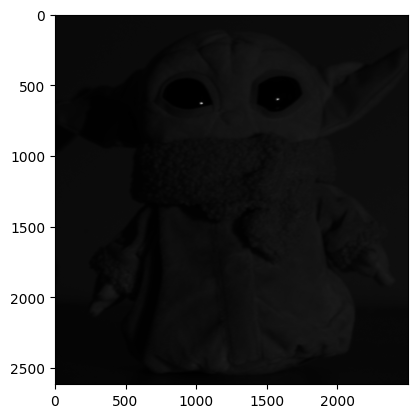

0.0 1.0
2616 2500


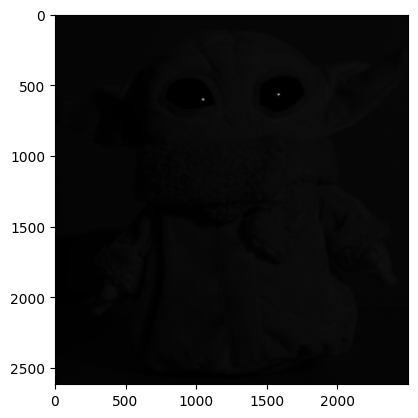

0.0 1.0
2616 2500


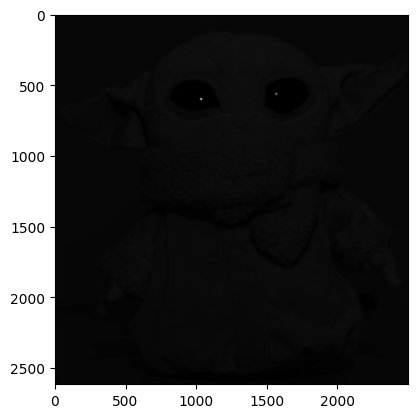

0.0 1.0
2616 2500


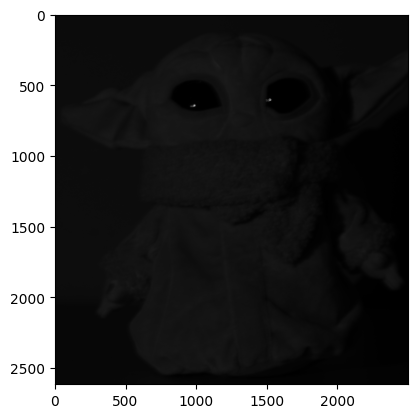

0.0 1.0
2616 2500


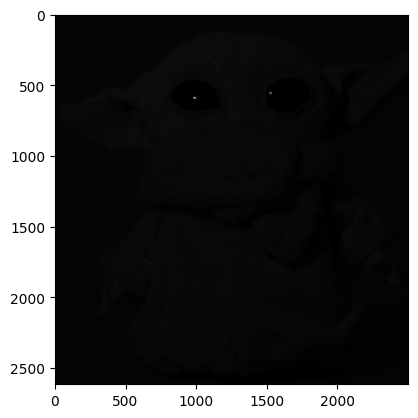

0.0 1.0
2616 2500


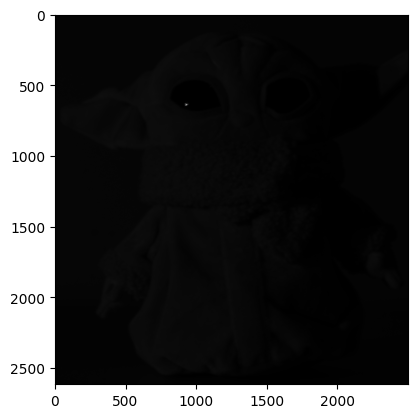

(6, 6540000)


In [287]:
I = []
h = 0
w = 0
for id in range(2, 8, 1):
    img = skimage.io.imread('data/photometric_stereo2/DSC_{}.tiff'.format(id))
    img = normalize_tiff(img)
    print(img.min(), img.max())
    luminance = convert_xyz(img)
    
    luminance = crop(luminance)
    
#     h, w = luminance.shape
    print(h, w)
#     luminance = resize(luminance, (h/2, w/2))
    
    plt.imshow(luminance, cmap='gray')
    plt.show()
    h, w = luminance.shape
    I.append(luminance.flatten())
I = np.stack(I, axis=0)

print(I.shape)

In [288]:
h, w

(2616, 2500)

In [357]:
def map_normal(normal_img):
    return (normal_img + 1.0)/2.0

def decompose_pseudo_normal(B):
    # input shape B: (3, HxW)
    # returns albedo and norm
    print(f'check B {B.shape}')
    A = np.linalg.norm(B, axis=0)
    N = B / A
    print(A.shape, N.shape)

    A = np.reshape(A, (h, w))
    N = np.reshape(N.T, (h, w, 3))
    print(f'reshaped albedo {A.shape}, reshaped normal map {N.shape}')
    
    N_vis = map_normal(N)
    print(N_vis.min(), N_vis.max())
    
    return A, N_vis

def normalize_01(depth):
    return (depth - depth.min()) / (depth.max() - depth.min())

In [358]:
# rank 3 decomposition
U, S, Vh = np.linalg.svd(I, full_matrices=False)
S = np.diag(S)
print(U.shape, S.shape, Vh.shape)
singular_vals = np.sqrt(S)[:3, :3]
print(singular_vals)

Le = np.matmul(U[:, :3], singular_vals)
Be = np.matmul(singular_vals, Vh[:3, :])
print(Le.shape, Be.shape)

(6, 6) (6, 6) (6, 6540000)
[[13.62962889  0.          0.        ]
 [ 0.          7.13785611  0.        ]
 [ 0.          0.          4.51934445]]
(6, 3) (3, 6540000)


In [359]:
be = np.reshape(np.transpose(Be), (h, w, 3))

# apply blur
sigma = 4.0
be_blur = []
for i in range(3):
    channel_blur = scipy.ndimage.gaussian_filter(be[:, :, i], sigma)
    be_blur.append(channel_blur)
be_blur = np.stack(be_blur, axis=2)
print(be_blur.shape)

# x and y gradients 
dx = np.gradient(be_blur, axis=1)
dy = np.gradient(be_blur, axis=0)
print(dx.shape, dy.shape)

(2616, 2500, 3)
(2616, 2500, 3) (2616, 2500, 3)


In [360]:
be_lighting = Be * np.array([[0.0, 0.0, -0.9648]]).T
be_lighting = np.reshape(be_lighting.T, (h, w, 3))
be_lighting = normalize_01(be_lighting)
plt.imshow(be_lighting, cmap='gray')
plt.axis('off')
plt.show()

In [361]:
be_allpix = np.reshape(be, (-1, 3))
dx_allpix = np.reshape(dx, (-1, 3))
dy_allpix = np.reshape(dy, (-1, 3))
print(be_allpix.shape)
# A
A1 = (be_allpix[:, 0] * dx_allpix[:, 1]) - (be_allpix[:, 1] * dx_allpix[:, 0])
A2 = (be_allpix[:, 0] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 0])
A3 = (be_allpix[:, 1] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 1])
A4 = -(be_allpix[:, 0] * dy_allpix[:, 1]) + (be_allpix[:, 1] * dy_allpix[:, 0])
A5 = -(be_allpix[:, 0] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 0])
A6 = -(be_allpix[:, 1] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 1])

A_mat = np.stack((A1, A2, A3, A4, A5, A6), axis=1)
A_mat.shape

(6540000, 3)


(6540000, 6)

In [362]:
u, s, vh = np.linalg.svd(A_mat, full_matrices=False)
print(u.shape, vh.shape)
x = vh[-1, :] # null space, last row of vh
print(x)
delta = np.array([[-x[2], x[5], 1], [x[1], -x[4], 0], [-x[0], x[3], 0]])
print(delta)

(6540000, 6) (6, 6)
[ 0.38296435  0.81798795 -0.28661608 -0.2348198  -0.21650347 -0.00843556]
[[ 0.28661608 -0.00843556  1.        ]
 [ 0.81798795  0.21650347  0.        ]
 [-0.38296435 -0.2348198   0.        ]]


In [363]:
delta_inv = np.linalg.inv(delta)
print(delta_inv.shape, be.shape)
be_integrate = np.matmul(delta_inv, Be)
print(be_integrate.shape)
# try hint
G_f = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])
G_temp = np.linalg.inv(G_f)
be_integrate_ = np.matmul(G_temp, be_integrate)
A_int, N_int = decompose_pseudo_normal(be_integrate_)

A_int.min(), A_int.max()
A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())

(3, 3) (2616, 2500, 3)
(3, 6540000)
check B (3, 6540000)
(6540000,) (3, 6540000)
reshaped albedo (2616, 2500), reshaped normal map (2616, 2500, 3)
0.00036493755778876924 0.9999999741567096


In [364]:
def render_lighting(Light):
    be_lighting = np.dot(Light, Be)
    I = np.reshape(be_lighting, (h, w))
    return I

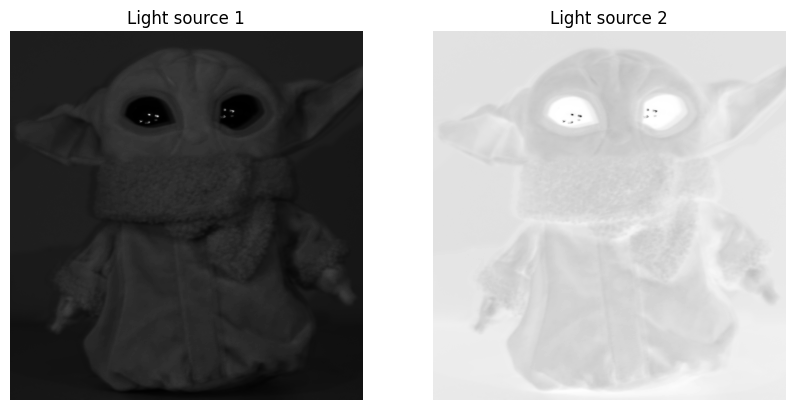

In [395]:
L1 = np.array([[-0.95, 0.0, 0.0]])
L2 = np.array([[0.1, 0.0, 0.0]])

I1 = render_lighting(L1)
I2 = render_lighting(L2)

%matplotlib inline 
plot_2fig(I1, I2, 'lighting_img2.png', 'Light source 1', 'Light source 2')

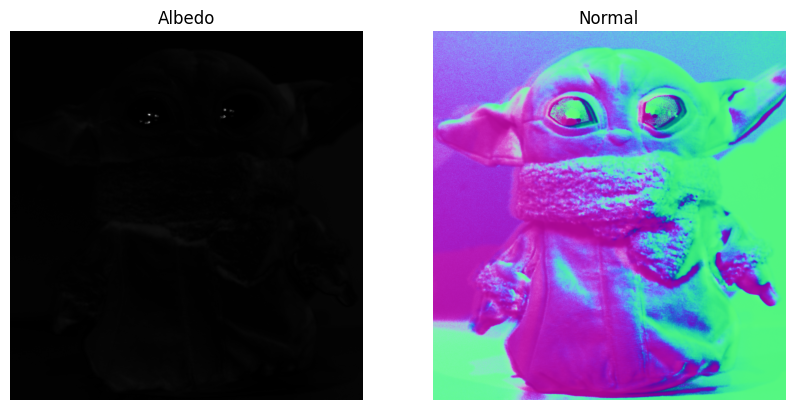

In [345]:
%matplotlib inline 
plot_2fig(A_int, N_int, 'sv_integrability_mine.png', 'Albedo', 'Normal')

In [346]:
eps = 1e-5
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

# Z = integrate_frankot(zx, zy)
Z = integrate_poisson(zx, zy)
Z.min(), Z.max()

(-1465.1787759668216, 2390.5790754365935)

0.0 1.0


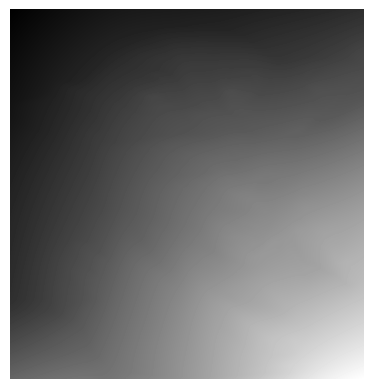

In [347]:
%matplotlib inline 
Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_mine.png')

In [354]:
import PyQt5
%matplotlib qt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
# x, y = np.meshgrid(np.arange(0,W,5), np.arange(0,H,5))
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
print(Z.shape, x.shape, y.shape)
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
ls = LightSource()

Z_temp = Z[0::5, 0::5]
print(Z_temp.shape)

color_shade = ls.shade(Z, plt.cm.gray)
# (control surface resolution using rstride and cstride)
ax.view_init(elev=90, azim=105)
surf = ax.plot_surface(x, y, Z, facecolors=color_shade, rstride=4, cstride=4)

# turn off axis
plt.axis('off')
plt.tight_layout()
# plt.savefig('imcddee_30.png', dpi=1200)
plt.show()

(2616, 2500) (2616, 2500) (2616, 2500)
(524, 500)


2023-11-23 14:39:54.250 python[1233:37531] +[CATransaction synchronize] called within transaction
2023-11-23 14:39:54.441 python[1233:37531] +[CATransaction synchronize] called within transaction


In [32]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_2fig_difference(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig1-fig2, cmap='gray')
    plt.title('Difference')
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_3fig(fig1, fig2, fig3, name=None, t1=None, t2=None, t3=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(t1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(t2)
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig3, cmap='gray')
    plt.title(t3)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()